In [1]:
# Basic
import numpy as np
from matplotlib import pyplot as plt

# For Dataset
from collections import deque, namedtuple
import random

# For solvers
from qpsolvers import solve_qp
from scipy.integrate import solve_ivp
from casadi import *

# For estimators
from torch import nn
import torch
import torch.nn.functional as F


from tqdm import tqdm

In [2]:
from utils.system import AAC
from utils.controller import LCBF
from utils.dataset import Dataset
from utils.estimator import *

In [ ]:
def sample_initial_state(p_min = 0, p_max = 2,
                         v_min = 18, v_max = 22,
                         z_min = 38, z_max = 42):
    p0 = np.random.uniform(p_min, p_max)
    v0 = np.random.uniform(v_min, v_max)
    z0 = np.random.uniform(z_min, z_max)
    return [p0, v0, z0] 


class Derivator:
    def __init__(self, dt):
        self.x = 0
        self.dt = dt
        
    def update(self, x_n):
        dx = (x_n - self.x)/dt
        
        self.x = x_n
        
        
        return dx
    

# Parameters

In [ ]:
dt = 0.02
simTime = 10

# Real parameters
v_lead = 22
v_des = 24
m  = 1650.0
g = 9.81

# 
f0 = 0.1
f1 = 5
f2 = 0.25


c_a = 0.3
c_d = 0.3
Th = 1.8

# Nominal parameters
f0_nom = 10*f0
f1_nom = 10*f1
f2_nom = 10*f2

p_slack = 2e-2
clf_rate = 5
cbf_rate = 5.

# Initial state
p0 = 0
v0 = 20
z0 = 40

x = [p0, v0 ,z0]

x_lst = []
u_lst = []
V_lst = []
B_lst = []
slack_lst = []


## Main

In [8]:
d = Dataset(('x', 'k', 'dh', 'dh_real'))

T = 10   # Number of experiences

aac = AAC(m, c_d, f0, f1, f2, v_lead)

cont = LCBF(0.8*m, c_a, c_d, f0_nom, f1_nom, f2_nom, v_lead, v_des, Th, clf_rate, cbf_rate, p_slack)

estimator = NN_affine(3)
e_f_opt,e_g_opt = torch.optim.Adam(estimator.e_f.model.parameters(), lr = 1e-4), torch.optim.Adam(estimator.e_g.model.parameters(), lr = 1e-4) 

weights = 0.2

x_lst = []
u_lst = []
V_lst = []
h_lst = []
dhe_lst = []
slack_lst = []


pbar = tqdm(total=simTime/dt*T)
for _ in range(T):
    x0 = sample_initial_state()
    x = x0
    derivator = Derivator(dt)
    
    xs = []
    us = []
    Vs = []
    hs = []
    dhes = []

    slacks = []

    for t in np.arange(0, simTime, dt): #simTime
        pbar.update(1)
        # Control reference
        v = x[1]
        u_ref = f0_nom * v**2 + f1_nom * v + f2_nom

        # Control Input
        k, slack_sol, V, dV, h, dh, dhe, dS = cont.compute_controller(x, u_ref, estimator, weights)

        # One step propagation in the system
        x_n = aac.update(x, k, t, dt)
        
        dh_real = derivator.update(h)

        d.update(x, k, dh, dh_real)
               
        xs.append(x)
        us.append(k)
        Vs.append(V)
        hs.append(h)
        dhes.append(dS - dh_real)
        slacks.append(slack_sol)

        x = x_n
        
        
    # Save data
    x_lst.append(xs)
    u_lst.append(us)
    V_lst.append(Vs)
    h_lst.append(hs)
    dhe_lst.append(dhes)
    slack_lst.append(slacks)

    # Train estimator
    sample = d.get_D()
        
    for x_i, k_i, dh_i, dh_real_i in zip(sample.x, sample.k, sample.dh, sample.dh_real):
        S_i = estimator.forward(x_i, k_i, None, train=True) + dh_i

        Loss = F.mse_loss(torch.tensor(dh_real_i),S_i)

        estimator.e_f.model.zero_grad()
        estimator.e_g.model.zero_grad()

        Loss.backward()
        e_f_opt.step()
        e_g_opt.step()

pbar.close()
    
        
        




 10%|█         | 500/5000.0 [00:20<00:23, 190.80it/s]





























/home/emanuelsamir/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
















































































































































































































































































100%|██████████| 5000/5000.0 [01:07<00:00, 73.81it/s] 


### No training

Text(0.5, 1.0, 'dH')

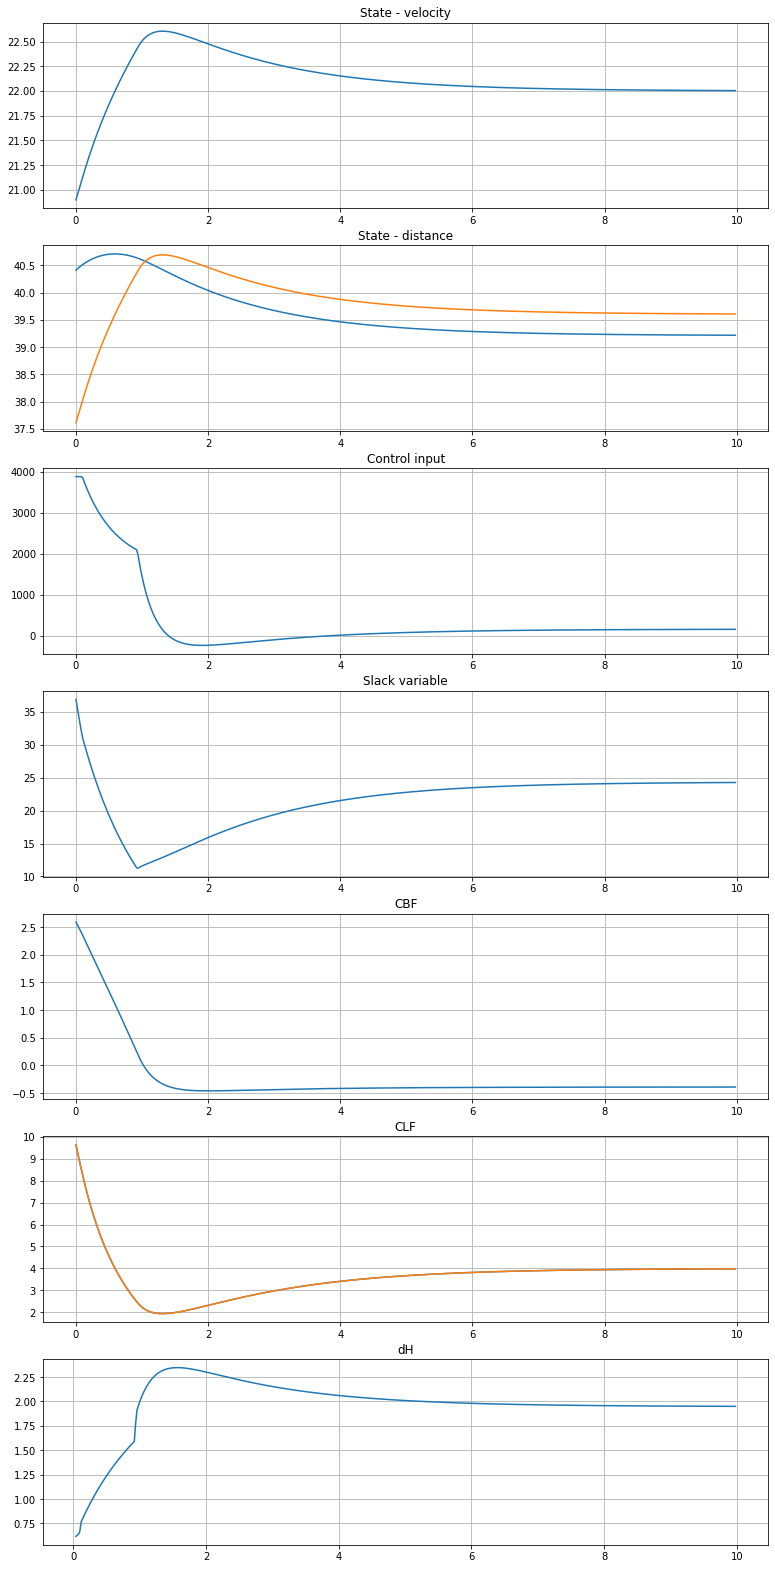

In [11]:
f,ax = plt.subplots(7,1,figsize = (13,28))
t_lns = np.arange(0, 10, dt)
exp = 0


ax[0].plot(t_lns, np.array(x_lst)[exp,:,1])
ax[0].grid(True)
ax[0].set_title('State - velocity')

ax[1].plot(t_lns, np.array(x_lst)[exp,:,2])
ax[1].grid(True)
ax[1].set_title('State - distance')

ax[1].plot(t_lns, Th*np.array(x_lst)[exp,:,1])#  + 0.5*(np.array(x_lst)[exp,:,1] - v_ego)/c_d/g)

ax[2].plot(t_lns, np.array(u_lst)[exp,:])
ax[2].grid(True)
ax[2].set_title('Control input')

ax[3].plot(t_lns, np.array(slack_lst)[exp,:])
ax[3].grid(True)
ax[3].set_title('Slack variable')

ax[4].plot(t_lns, np.array(h_lst)[exp,:])
ax[4].grid(True)
ax[4].set_title('CBF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')

ax[5].plot(t_lns, np.array(V_lst)[exp,:])
ax[5].grid(True)
ax[5].set_title('CLF')

ax[6].plot(t_lns[2:], np.array(dhe_lst)[exp,2:])
ax[6].grid(True)
ax[6].set_title('dH')
